# Libraries 

In [31]:
import pandas
import pm4py
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Step 1 - loading and splitting the dataset.
This ensures that we train our models on one subset of deterministic data and evaluate their performance on unseen stochastic log (test set).

In [33]:
file_path = 'BPI_Challenge_2012.xes'
log = pm4py.read_xes(file_path)
log = pm4py.format_dataframe(log, case_id='case:concept:name', activity_key='concept:name',
                                       timestamp_key='time:timestamp')
log.head()

parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,@@index,@@case_index
0,112,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000,0,0
1,112,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000,1,0
2,112,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000,2,0
3,112,SCHEDULE,W_Completeren aanvraag,2011-10-01 00:39:38.875000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000,3,0
4,NaN,START,W_Completeren aanvraag,2011-10-01 11:36:46.437000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000,4,0


In [34]:
unique_cases = log['case:concept:name'].unique()
train_cases, test_cases = train_test_split(unique_cases, test_size=0.2, random_state=42)

train_df = log[log['case:concept:name'].isin(train_cases)]
test_df = log[log['case:concept:name'].isin(test_cases)]

# Step 2 adding the noise to test log
Tramsforms our test log from deterministically known (one we're sure about its events) to one with noise similiarly to what they did in the papper (Section 4b) - to create different levels of uncertainty.
Data Preparation and Preprocessing: To prepare the 
uncertain log, we controlled the)  parameterPa, which sets the probability of the original transiti n
to be assigned the highest probability among its set of
alternative transitio. 



In [36]:
def add_noise_to_log(df, Pa):
    noisy_df = df.copy()
    
    all_activities = df['concept:name'].unique()

    for idx, row in noisy_df.iterrows():
        original_activity = row['concept:name']

        # with probability 1 - Pa replace the activity
        if random.random() > Pa:
            alternative_activities = list(all_activities[all_activities != original_activity])  # exclude the original activity
            if alternative_activities:  # if there are alternative activities available randomly pick one 
                new_activity = random.choice(alternative_activities)  
                noisy_df.at[idx, 'concept:name'] = new_activity #replacing the activity
    
    return noisy_df
    
Pa_values = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
noisy_test_logs = {Pa: add_noise_to_log(test_df, Pa) for Pa in Pa_values}

# Step 3 - Calculating Transition Probabilities
We performed it by firstly, counting the transitions between activities, which we later converted to probabilities. 
We also defined a function that predicts the next event in a sequence based on the calculated transition probabilities.

In [38]:
df = train_df.sort_values(by=['case:concept:name', 'time:timestamp'])
# converts each case to a list of events that happened in each case
grouped = df.groupby('case:concept:name')['concept:name'].apply(list)
grouped.head()

case:concept:name
173691    [A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...
173694    [A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...
173700         [A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED]
173703    [A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...
173706    [A_SUBMITTED, A_PARTLYSUBMITTED, W_Afhandelen ...
Name: concept:name, dtype: object

In [39]:
transition_counts = defaultdict(lambda: defaultdict(int))

# count and save the number of event transitions, which later will be converted to probab. and saved in transit matrix 
for events in grouped:
    for i in range(len(events) - 1):
        current_event = events[i]
        next_event = events[i + 1]
        transition_counts[current_event][next_event] += 1

transition_matrix = {}
for current_event, next_events in transition_counts.items():
    total_count = sum(next_events.values())
    transition_matrix[current_event] = {event: count / total_count for event, count in next_events.items()}

In [40]:
def predict_next_event(current_event):
    if current_event in transition_matrix:
        next_events = transition_matrix[current_event]
        return random.choices(list(next_events.keys()), weights=next_events.values())[0]
    else:
        # if there's no data in matrix on current event, return a random event
        return random.choice(list(transition_matrix.keys()))

# Step 4 - Sequence Probability Model
Here we implemented the Sequence Probability Model from Section 3C in the paper. This model predicts the next event based on the entire sequence of prior events, in other words it uses history to improve 
trace recovery accurac

Notice: We chose the length up to 4 (as you will se later the optimal value) y

In [42]:
sequence_probs = defaultdict(lambda: defaultdict(int))

# = frequencies of subsequences of length 1 to n-1
for events in grouped:
    for i in range(1, len(events)):
        for j in range(max(0, i - 4), i):  # Use subsequences of up to length 4
            subsequence = tuple(events[j:i])  # Create subsequence
            next_event = events[i]  # The event that follows the subsequence
            sequence_probs[subsequence][next_event] += 1

# converting to probs
for subsequence, next_events in sequence_probs.items():
    total_count = sum(next_events.values())
    sequence_probs[subsequence] = {event: count / total_count for event, count in next_events.items()}

In [43]:
def seq_predict_next_event(sequence):
    # finding the longest subsequence
    for i in range(len(sequence), 0, -1):
        subseq = tuple(sequence[-i:])
        if subseq in sequence_probs:
            next_events = sequence_probs[subseq]
            next_event = random.choices(list(next_events.keys()), weights=next_events.values())[0]
            return next_event
            
    # return a random event if no subsequence matches
    return random.choice(list(sequence_probs.keys()))


# Step 5 - Evaluation and Conclusions
We test the models on noisy test log and checked for two dependencies: 
1.  accuracies for different `Pa` values
2.  accuracies of Sequence Probability Model for different sequence lengths


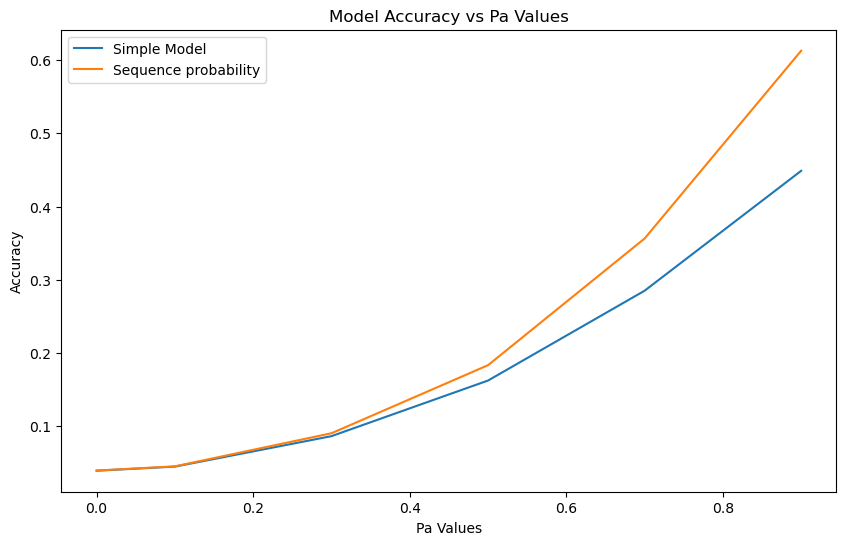

In [45]:
def test_model_on_noisy_log(noisy_log, simple_model):
    
    correct_predictions = 0
    total_predictions = 0
    if simple_model: #regular Markov chain probabilities
        for events in noisy_log.groupby('case:concept:name')['concept:name'].apply(list):
            for i in range(len(events) - 1):
                current_event = events[i]
                actual_next_event = events[i + 1]
                predicted_next_event = predict_next_event(current_event)
                
                if predicted_next_event == actual_next_event:
                    correct_predictions += 1
                total_predictions += 1      
    else:
        for case, events in noisy_log.groupby('case:concept:name')['concept:name'].apply(list).items():
            for i in range(1, len(events)):
                current_sequence = events[:i]
                actual_next_event = events[i]
                predicted_next_event = seq_predict_next_event(current_sequence)
                
                if predicted_next_event == actual_next_event:
                    correct_predictions += 1
                total_predictions += 1
    accuracy = correct_predictions / total_predictions
    return accuracy if total_predictions > 0 else 0

# testing our models on different noisy log 
accuracy_results = {Pa: {} for Pa in Pa_values}
for Pa, noisy_log in noisy_test_logs.items():
    accuracy_results[Pa]['Simple Model'] = test_model_on_noisy_log(noisy_log, True)
    accuracy_results[Pa]['Sequence probability'] = test_model_on_noisy_log(noisy_log, False)


plt.figure(figsize=(10, 6))
for model in ['Simple Model', 'Sequence probability']:
    plt.plot(Pa_values, [accuracy_results[Pa][model] for Pa in Pa_values], label=model)

plt.xlabel('Pa Values')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Pa Values')
plt.legend()
plt.show()

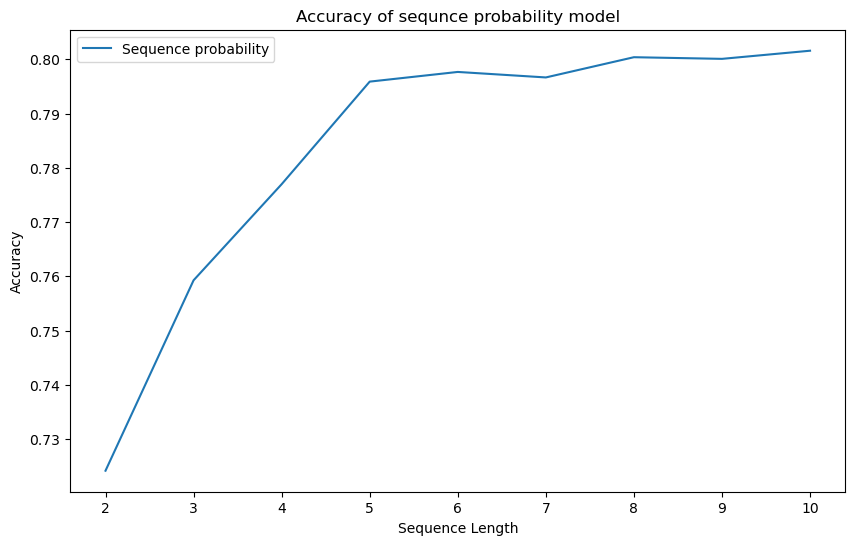

In [46]:
def calculate_sequence_probs_with_length(train_df, max_length):
    sequence_probs = defaultdict(lambda: defaultdict(int))
    grouped = train_df.groupby('case:concept:name')['concept:name'].apply(list)
    
    # transition counts for sequences up to max_length
    for events in grouped:
        for i in range(1, len(events)):
            for j in range(max(0, i - max_length), i):
                subsequence = tuple(events[j:i])
                next_event = events[i]
                sequence_probs[subsequence][next_event] += 1
    
    # converting counts to probabilities
    for subsequence, next_events in sequence_probs.items():
        total_count = sum(next_events.values())
        sequence_probs[subsequence] = {event: count / total_count for event, count in next_events.items()}
    
    return sequence_probs
sequence_lengths = range(2, 11)
accuracy_length_results = {length: {} for length in sequence_lengths}

for length in sequence_lengths:
    sequence_probs = calculate_sequence_probs_with_length(train_df, length)
    accuracy_length_results[length]['Sequence probability'] = test_model_on_noisy_log(test_df, False)


plt.figure(figsize=(10, 6))
plt.plot(sequence_lengths, [accuracy_length_results[length]['Sequence probability'] for length in sequence_lengths], label=model)
plt.xlabel('Sequence Length')
plt.ylabel('Accuracy')
plt.title('Accuracy of sequnce probability model')
plt.legend()
plt.show()


*Explanation of Results:*

1. Model Accuracy vs Pa Values
As Pa increases, indicating less noise (higher probability of having the correct event), the accuracy of both models increases. 
However, the gap between the two models widens as Pa increases, meaning that the Sequence Probability Model benefits more from having less noise.
For lower Pa values (high noise), both models perform similarly.

2. Accuracy vs Sequence Length for Sequnce Probability Model:
This graph demonstrates how the accuracy of the Sequence Probability Model changes as the sequence length used for predicting the next event increases. The accuracy steadily improves as the model considers longer sequences (up to length 4 or 5), implying that including more historical context improves predictions.
Including more historical context (sequence length) improves accuracy, but this improvement plateaus after a certain length. This shows that short-term memory (4-5 events) is generally sufficient for good prediction in this dataset.